# Function: Monte Carlo Stock Price Generation

In [21]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime, timedelta

# Monte Carlo Stock Price Simulation for configurable intervals
def generate_stock_price_data(interval=5, hours=23):
    """
    Generate stock price data for specified hours using Monte Carlo method
    
    Parameters:
    -----------
    interval : int, default=5
        Time interval in seconds between each price point
    hours : int, default=23
        Number of hours to simulate (6 PM to 5 PM next day = 23 hours)
    """
    # Parameters
    initial_price = 100.0  # Starting stock price
    drift = 0.0001  # Daily drift (scaled for interval)
    volatility = 0.02  # Daily volatility
    
    # Calculate time step and number of steps based on interval
    time_step = interval / (24 * 60 * 60)  # Convert seconds to fraction of day
    num_steps = int(hours * 60 * 60 / interval)  # Total intervals in specified hours
    
    # Generate time series starting at 6 PM (18:00)
    start_time = datetime.now().replace(hour=18, minute=0, second=0, microsecond=0)
    timestamps = [start_time + timedelta(seconds=i*interval) for i in range(num_steps)]
    
    # Monte Carlo simulation using Geometric Brownian Motion
    prices = [initial_price]
    
    for i in range(1, num_steps):
        # Random shock (normal distribution)
        random_shock = np.random.normal(0, 1)
        
        # Calculate price change using GBM formula
        price_change = drift * time_step + volatility * np.sqrt(time_step) * random_shock
        
        # Calculate new price
        new_price = prices[-1] * np.exp(price_change)
        prices.append(new_price)
    
    # Create DataFrame
    stock_data = pd.DataFrame({
        'timestamp': timestamps,
        'price': prices
    })
    
    return stock_data


# Function: OANDA Stock Price Generation

In [22]:
# OANDA Live FXTrade API Connection
import requests
import pandas as pd
from datetime import datetime, timedelta
import json

def get_oanda_data(api_key, account_id, instrument='USD_CAD', granularity='S5', hours=10):
    """
    Connect to OANDA live fxtrade environment and fetch real market data
    
    Parameters:
    -----------
    api_key : str
        Your OANDA API key from live account
    account_id : str
        Your OANDA live account ID
    instrument : str, default='USD_CAD'
        Currency pair to fetch
    granularity : str, default='S5'
        Time granularity (S5 = 5 seconds)
    hours : int, default=10
        Number of hours of historical data to fetch
    
    Returns:
    --------
    pandas.DataFrame
        DataFrame with real market data
    """
    
    # LIVE OANDA API URL (NOT practice!)
    BASE_URL = "https://api-fxtrade.oanda.com"
    
    print("🔴 CONNECTING TO OANDA LIVE FXTRADE ENVIRONMENT")
    print("=" * 55)
    print("⚠️  WARNING: This will connect to LIVE market data")
    print(f"📊 Requesting: {instrument} | {granularity} | Last {hours} hours")
    print("=" * 55)
    
    # Validate inputs
    if not api_key or api_key == "your_live_api_key_here":
        print("❌ ERROR: Live API key is required!")
        print("\n🔧 TO GET YOUR LIVE OANDA CREDENTIALS:")
        print("1. Log into your OANDA account at: https://www.oanda.com/")
        print("2. Go to 'Manage API Access' in account settings")
        print("3. Generate a Personal Access Token")
        print("4. Copy your Account ID from account overview")
        print("\n💡 USAGE:")
        print("live_data = connect_oanda_live(")
        print("    api_key='your_actual_api_key',")
        print("    account_id='your_actual_account_id'")
        print(")")
        return None
    
    if not account_id or account_id == "your_live_account_id_here":
        print("❌ ERROR: Live Account ID is required!")
        return None
    
    # Headers for API request
    headers = {
        'Authorization': f'Bearer {api_key}',
        'Content-Type': 'application/json',
        'Accept': 'application/json'
    }
    
    # Calculate count based on granularity and hours
    if granularity == 'S5':
        count = min(hours * 60 * 12, 5000)  # 12 five-second intervals per minute, max 5000
    elif granularity == 'S10':
        count = min(hours * 60 * 6, 5000)   # 6 ten-second intervals per minute
    elif granularity == 'M1':
        count = min(hours * 60, 5000)       # 60 one-minute intervals per hour
    elif granularity == 'M5':
        count = min(hours * 12, 5000)       # 12 five-minute intervals per hour
    else:
        count = min(7200, 5000)  # Default fallback
    
    # API endpoint for historical candles
    url = f"{BASE_URL}/v3/instruments/{instrument}/candles"
    
    # Parameters for the request
    params = {
        'count': count,
        'granularity': granularity#,
        # 'price': 'MBA',  # Mid, Bid, Ask prices
        # 'includeFirst': 'true'
    }
    
    try:
        print(f"🌐 Making API request to OANDA live servers...")
        print(f"   URL: {url}")
        print(f"   Params: {params}")
        
        # Make the API request
        response = requests.get(url, headers=headers, params=params, timeout=30)
        
        # Check for HTTP errors
        if response.status_code == 401:
            print("❌ AUTHENTICATION ERROR (401)")
            print("   • Check your API key is correct")
            print("   • Ensure your API key has proper permissions")
            print("   • Verify you're using the live account API key")
            return None
        elif response.status_code == 403:
            print("❌ FORBIDDEN ERROR (403)")
            print("   • Your account may not have API access enabled")
            print("   • Check if your account is verified and funded")
            return None
        elif response.status_code == 404:
            print("❌ NOT FOUND ERROR (404)")
            print(f"   • Check instrument name: {instrument}")
            print(f"   • Check granularity: {granularity}")
            return None
        elif response.status_code != 200:
            print(f"❌ HTTP ERROR {response.status_code}")
            print(f"   Response: {response.text}")
            return None
        
        # Parse JSON response
        data = response.json()
        
        if 'candles' not in data:
            print("❌ ERROR: No candles data in response")
            print(f"Response: {data}")
            return None
        
        candles = data['candles']
        print(f"✅ Successfully received {len(candles)} candles from OANDA live")
        
        # Convert to DataFrame
        market_data = []
        for candle in candles:
            # Convert timestamp to New York timezone and remove timezone info
            timestamp = pd.to_datetime(candle['time'])
            # Convert to New York timezone
            timestamp = timestamp.tz_convert('America/New_York')
            # Remove timezone info (localize to None)
            timestamp = timestamp.tz_localize(None)
            
            # Extract OHLC data
            mid = candle.get('mid', {})
            bid = candle.get('bid', {})
            ask = candle.get('ask', {})
            
            if not mid:
                continue  # Skip if no mid prices
            
            # Get prices
            open_price = float(mid['o'])
            high_price = float(mid['h'])
            low_price = float(mid['l'])
            close_price = float(mid['c'])
            
            bid_price = float(bid.get('c', close_price - 0.0001))
            ask_price = float(ask.get('c', close_price + 0.0001))
            
            # Calculate spread in pips (for USD/CAD, 1 pip = 0.0001)
            spread_pips = (ask_price - bid_price) * 10000
            
            market_data.append({
                'timestamp': timestamp,
                'open': open_price,
                'high': high_price,
                'low': low_price,
                'close': close_price,
                'mid': close_price,
                'bid': bid_price,
                'ask': ask_price,
                'volume': candle.get('volume', 0),
                'spread_pips': round(spread_pips, 1),
                'complete': candle.get('complete', True)
            })
        
        if not market_data:
            print("❌ ERROR: No valid market data received")
            return None
        
        # Create DataFrame
        df = pd.DataFrame(market_data)
        
        # Add price column for compatibility with EMA functions
        df['price'] = df['close']
        
        # Sort by timestamp to ensure chronological order
        df = df.sort_values('timestamp').reset_index(drop=True)
        
        print(f"\n📊 LIVE MARKET DATA SUMMARY:")
        print(f"   • Instrument: {instrument}")
        print(f"   • Granularity: {granularity}")
        print(f"   • Total candles: {len(df):,}")
        print(f"   • Time range: {df['timestamp'].min()} to {df['timestamp'].max()}")
        print(f"   • Price range: {df['close'].min():.5f} - {df['close'].max():.5f}")
        print(f"   • Current price: {df['close'].iloc[-1]:.5f}")
        print(f"   • Average spread: {df['spread_pips'].mean():.1f} pips")
        
        # Show latest data
        print(f"\n📈 LATEST 3 CANDLES:")
        latest_cols = ['timestamp', 'open', 'high', 'low', 'close', 'bid', 'ask', 'spread_pips']
        print(df[latest_cols].tail(3).to_string(index=False, float_format='%.5f'))
        

        # return the dataframe with timestamp and  price columns
        return df[['timestamp', 'price']]
        
    except requests.exceptions.Timeout:
        print("❌ TIMEOUT ERROR: Request took too long")
        print("   • Try again or reduce the number of hours")
        return None
    except requests.exceptions.ConnectionError:
        print("❌ CONNECTION ERROR: Cannot reach OANDA servers")
        print("   • Check your internet connection")
        print("   • OANDA servers may be temporarily unavailable")
        return None
    except requests.exceptions.RequestException as e:
        print(f"❌ REQUEST ERROR: {e}")
        return None
    except json.JSONDecodeError:
        print("❌ JSON ERROR: Invalid response from OANDA")
        print(f"   Response: {response.text[:200]}...")
        return None
    except Exception as e:
        print(f"❌ UNEXPECTED ERROR: {e}")
        return None

# # Example usage (you need to provide your actual credentials)
# print("🔧 OANDA LIVE TRADING API SETUP")
# print("=" * 40)
# print("To fetch live USD/CAD data, use:")
# print()
# print("live_usdcad = connect_oanda_live(")
# print("    api_key='your_actual_live_api_key',")
# print("    account_id='your_actual_live_account_id',")
# print("    instrument='USD_CAD',")
# print("    granularity='S5',")
# print("    hours=10")
# print(")")
# print()
# print("⚠️  Replace with your actual OANDA live credentials!")
# print("📖 Get credentials from: https://www.oanda.com/account/tpa/personal_token")






# Function: Transform 5 second data to variable interval data

In [23]:
def create_variable_interval_data(base_df, min_interval, max_interval):
    """
    Create a new DataFrame with variable time intervals by randomly removing rows
    
    Parameters:
    -----------
    base_df : pandas.DataFrame
        Base DataFrame with 'timestamp' and 'price' columns
    min_interval : int, default=1
        Minimum time interval in seconds
    max_interval : int, default=60
        Maximum time interval in seconds
    
    Returns:
    --------
    pandas.DataFrame
        New DataFrame with variable time intervals
    """
    
    # Start with first row
    variable_data = [base_df.iloc[0]]
    current_index = 0
    
    while current_index < len(base_df) - 1:
        # Generate random interval between min and max seconds
        random_interval = np.random.randint(min_interval, max_interval + 1)
        
        # Move forward by this interval (in seconds)
        next_index = current_index + random_interval
        
        # Make sure we don't exceed the DataFrame length
        if next_index < len(base_df):
            variable_data.append(base_df.iloc[next_index])
            current_index = next_index
        else:
            # Add the last row if we haven't reached it
            if current_index != len(base_df) - 1:
                variable_data.append(base_df.iloc[-1])
            break
    
    # Create new DataFrame
    variable_df = pd.DataFrame(variable_data).reset_index(drop=True)
    
    return variable_df


# Function: Calculate Data Frame's time based EMAs (including TEMA)

In [24]:
import numpy as np
import pandas as pd
from datetime import timedelta

def calculate_time_based_ema(stock_df, type=1, period_minutes=15):
    """
    Calculate Exponential Moving Average based on actual time period (minutes) using timestamps.
    
    Parameters:
    -----------
    stock_df : pandas.DataFrame
        DataFrame containing 'timestamp' and 'price' columns
    period_minutes : int, default=15
        The time period in minutes for the EMA calculation
    
    Returns:
    --------
    pandas.Series
        Series containing the EMA values aligned with the input DataFrame index
    
    Notes:
    ------
    - This function is truly time-based and uses actual timestamps, not row counts
    - The smoothing factor (alpha) is calculated based on the actual time period
    - Works with any data frequency (1-second, 5-second, 1-minute, etc.)
    - EMA formula: EMA_today = (Price_today * α) + (EMA_yesterday * (1 - α))
    - Where α = 2 / (N + 1), and N is calculated from the actual time period
    """
    
    # Validate input DataFrame
    if not isinstance(stock_df, pd.DataFrame):
        raise ValueError("stock_df must be a pandas DataFrame")
    
    if 'timestamp' not in stock_df.columns or 'price' not in stock_df.columns:
        raise ValueError("DataFrame must contain 'timestamp' and 'price' columns")
    
    if len(stock_df) == 0:
        return pd.Series(dtype=float)
    
    if len(stock_df) < 2:
        # If only one data point, return the price itself
        return pd.Series([stock_df['price'].iloc[0]], index=stock_df.index)
    
    # Calculate the actual time interval between data points (in seconds)
    time_diffs = stock_df['timestamp'].diff().dropna()
    avg_interval_seconds = time_diffs.dt.total_seconds().mean()
    
    # Calculate the equivalent number of periods for the specified time window
    period_seconds = period_minutes * 60
    equivalent_periods = period_seconds / avg_interval_seconds
    
    # Calculate smoothing factor (alpha) based on equivalent periods
    # Using standard EMA formula: α = 2 / (N + 1)
    alpha = 2.0 / (equivalent_periods + 1)
    
    # Initialize EMA series
    ema_values = []
    dema_values = []
    tema_values = []
    purple_values = []
    
    # First EMA value is the first price
    first_price = stock_df['price'].iloc[0]
    ema_values.append(first_price)
    dema_values.append(first_price)
    tema_values.append(first_price)
    purple_values.append(first_price)  # Initial purple value
    
    # Calculate EMA for subsequent values using time-based smoothing
    for i in range(1, len(stock_df)):
        current_price = stock_df['price'].iloc[i]
        previous_ema = ema_values[-1]
        previous_dema = dema_values[-1]
        previous_tema = tema_values[-1]

        # Calculate time elapsed since previous data point
        time_elapsed = (stock_df['timestamp'].iloc[i] - stock_df['timestamp'].iloc[i-1]).total_seconds()
        
        # Adjust alpha based on actual time elapsed vs expected interval
        # This ensures consistency regardless of irregular timestamps
        time_weight = time_elapsed / avg_interval_seconds
        adjusted_alpha = 1 - (1 - alpha) ** time_weight
        
        # EMA formula with time-adjusted smoothing
        current_ema = adjusted_alpha * current_price + (1 - adjusted_alpha) * previous_ema
        current_dema = adjusted_alpha * current_ema + (1 - adjusted_alpha) * previous_dema
        current_tema = adjusted_alpha * current_dema + (1 - adjusted_alpha) * previous_tema
        
        ema_values.append(current_ema)
        dema_values.append(current_dema)
        tema_values.append(current_tema)
        purple_values.append(3 * (current_ema - current_dema) + current_tema)
    
    # Return as pandas Series with the same index as input DataFrame
    if type == 1:
        return pd.Series(ema_values, index=stock_df.index, name=f'EMA_{period_minutes}min')
    elif type == 2:
        return pd.Series(dema_values, index=stock_df.index, name=f'DEMA_{period_minutes}min')
    elif type == 3:
        return pd.Series(purple_values, index=stock_df.index, name=f'TEMA_{period_minutes}min')
    else:
        raise ValueError("Invalid type specified. Use 1 for EMA, 2 for DEMA, or 3 for TEMA.")


# Class: Time-based Streaming Moving Averages (EMA DEMA TEMA)

In [25]:
# 🕐 TIME-BASED STREAMING MOVING AVERAGES CLASS
from collections import deque
import pandas as pd
from datetime import datetime, timedelta

class TimeBasedStreamingMA:
    """
    Time-based streaming moving average calculator that uses actual timestamps
    instead of fixed number of data points. Supports SMA, EMA, DEMA, and TEMA.
    
    Key Features:
    - Uses time windows (e.g., "5 minutes", "1 hour") instead of row counts
    - Automatically handles irregular time intervals
    - Maintains time-weighted calculations
    - Supports all four MA types with time-based logic
    """
    
    def __init__(self, time_window, ma_type='SMA', alpha=None):
        """
        Initialize the time-based streaming moving average calculator.
        
        Parameters:
        -----------
        time_window : str or timedelta
            Time window for calculations (e.g., '5min', '1H', '30s')
            Can be pandas timedelta string or datetime.timedelta object
        ma_type : str
            Type of moving average: 'SMA', 'EMA', 'DEMA', 'TEMA'
        alpha : float, optional
            Smoothing factor for EMA. If None, calculated based on time window
        """
        self.ma_type = ma_type.upper()
        
        # Validate MA type
        if self.ma_type not in ['SMA', 'EMA', 'DEMA', 'TEMA']:
            raise ValueError("ma_type must be one of: 'SMA', 'EMA', 'DEMA', 'TEMA'")
        
        # Convert time window to timedelta
        if isinstance(time_window, str):
            # Handle common abbreviations and deprecated formats
            time_window_str = time_window.replace('H', 'h')  # Fix deprecated 'H' format
            self.time_window = pd.Timedelta(time_window_str)
        elif isinstance(time_window, timedelta):
            self.time_window = pd.Timedelta(time_window)
        else:
            raise ValueError("time_window must be a string (e.g., '5min') or timedelta object")
        
        # Store original time window specification
        self.time_window_str = str(time_window)
        
        # Calculate alpha for EMA-based calculations
        if alpha is None:
            # Convert time window to approximate number of periods for alpha calculation
            # Assume 1-minute base period for alpha calculation
            minutes = self.time_window.total_seconds() / 60
            equivalent_periods = max(1, minutes)  # At least 1 period
            self.alpha = 2.0 / (equivalent_periods + 1)
        else:
            if not (0 < alpha < 1):
                raise ValueError("alpha must be between 0 and 1")
            self.alpha = alpha
        
        # Initialize data storage - we need to keep all data within time window for SMA
        self.data_points = deque()  # Store (timestamp, price) tuples
        self.timestamps = deque()   # Store just timestamps for quick access
        
        # For EMA, DEMA, TEMA - maintain running calculations
        if self.ma_type != 'SMA':
            self.ema1 = None  # First EMA
            self.ema2 = None  # Second EMA (for DEMA, TEMA)
            self.ema3 = None  # Third EMA (for TEMA)
            self.initialized = False
            self.last_timestamp = None
        
        self.data_count = 0
        
    def _clean_old_data(self, current_timestamp):
        """Remove data points older than the time window."""
        cutoff_time = current_timestamp - self.time_window
        
        # Remove old data points
        while self.data_points and self.data_points[0][0] < cutoff_time:
            self.data_points.popleft()
            if self.timestamps:
                self.timestamps.popleft()
    
    def _calculate_time_weight(self, current_timestamp, last_timestamp):
        """Calculate time-based weight for EMA calculations."""
        if last_timestamp is None:
            return self.alpha
        
        # Calculate time elapsed in seconds
        time_elapsed = (current_timestamp - last_timestamp).total_seconds()
        
        # Handle edge cases
        if time_elapsed <= 0:
            return self.alpha  # No time elapsed, use base alpha
        
        # Assume base interval for alpha calculation (e.g., 60 seconds)
        base_interval = 60.0  # 1 minute
        
        # Adjust alpha based on actual time elapsed
        time_factor = time_elapsed / base_interval
        
        # Prevent issues with very small alpha values and large time factors
        if self.alpha <= 0 or self.alpha >= 1:
            return self.alpha
        
        # Apply time-weighted alpha: more time elapsed = more weight to new data
        try:
            adjusted_alpha = 1 - (1 - self.alpha) ** time_factor
            return min(1.0, max(0.0, adjusted_alpha))  # Clamp between 0 and 1
        except (ZeroDivisionError, OverflowError, ValueError):
            # Fallback to base alpha if calculation fails
            return self.alpha
    
    def add_data_point(self, timestamp, price):
        """
        Add a new data point and calculate the updated time-based moving average.
        
        Parameters:
        -----------
        timestamp : datetime or str
            Timestamp of the data point
        price : float
            Price value
            
        Returns:
        --------
        dict
            Dictionary containing current MA, time window info, and metadata
        """
        # Convert timestamp to datetime if it's a string
        if isinstance(timestamp, str):
            timestamp = pd.to_datetime(timestamp)
        
        self.data_count += 1
        
        # Clean old data points outside time window
        self._clean_old_data(timestamp)
        
        # Add new data point
        self.data_points.append((timestamp, price))
        self.timestamps.append(timestamp)
        
        if self.ma_type == 'SMA':
            return self._calculate_time_sma(timestamp, price)
        elif self.ma_type == 'EMA':
            return self._calculate_time_ema(timestamp, price)
        elif self.ma_type == 'DEMA':
            return self._calculate_time_dema(timestamp, price)
        elif self.ma_type == 'TEMA':
            return self._calculate_time_tema(timestamp, price)
    
    def _calculate_time_sma(self, timestamp, price, return_full_window=False):
        """Calculate time-based Simple Moving Average."""
        # Calculate SMA using all data points within time window
        if len(self.data_points) == 0:
            current_ma = price
        else:
            total_price = sum(p for t, p in self.data_points)
            current_ma = total_price / len(self.data_points)
        
        if return_full_window:
            return {
                'timestamp': timestamp,
                'price': price,
                'moving_average': current_ma,
                'data_points_count': len(self.data_points),
                'time_window': self.time_window_str,
                'window_start': self.timestamps[0] if self.timestamps else timestamp,
                'window_end': timestamp,
                'time_span_actual': (timestamp - self.timestamps[0]).total_seconds() if self.timestamps else 0,
                'time_span_target': self.time_window.total_seconds(),
                'is_full_window': (timestamp - self.timestamps[0]) >= self.time_window if self.timestamps else False,
                'ma_type': 'Time-SMA'
            }
        return current_ma
    
    def _calculate_time_ema(self, timestamp, price, return_full_window=False):
        """Calculate time-based Exponential Moving Average."""
        if not self.initialized:
            # Initialize with first price
            self.ema1 = price
            self.initialized = True
            self.last_timestamp = timestamp
            time_weight = self.alpha
        else:
            # Calculate time-adjusted alpha
            time_weight = self._calculate_time_weight(timestamp, self.last_timestamp)
            # EMA calculation with time weighting
            self.ema1 = time_weight * price + (1 - time_weight) * self.ema1
            self.last_timestamp = timestamp
        
        if return_full_window:
            return {
                'timestamp': timestamp,
                'price': price,
                'moving_average': self.ema1,
                'data_points_count': self.data_count,
                'time_window': self.time_window_str,
                'window_start': self.timestamps[0] if self.timestamps else timestamp,
                'window_end': timestamp,
                'time_span_actual': (timestamp - self.timestamps[0]).total_seconds() if self.timestamps else 0,
                'time_span_target': self.time_window.total_seconds(),
                'is_full_window': (timestamp - self.timestamps[0]) >= self.time_window if self.timestamps else False,
                'ma_type': 'Time-EMA',
                'alpha_used': time_weight,
                'base_alpha': self.alpha
        }
        return self.ema1
        
    def _calculate_time_dema(self, timestamp, price, return_full_window=False):
        """Calculate time-based Double Exponential Moving Average."""
        if not self.initialized:
            # Initialize with first price
            self.ema1 = price
            self.ema2 = price
            self.initialized = True
            self.last_timestamp = timestamp
            time_weight = self.alpha
        else:
            # Calculate time-adjusted alpha
            time_weight = self._calculate_time_weight(timestamp, self.last_timestamp)
            # First EMA
            self.ema1 = time_weight * price + (1 - time_weight) * self.ema1
            # Second EMA (EMA of first EMA)
            self.ema2 = time_weight * self.ema1 + (1 - time_weight) * self.ema2
            self.last_timestamp = timestamp
        
        # DEMA = 2 * EMA1 - EMA2
        dema = 2 * self.ema1 - self.ema2
        
        if return_full_window:
            return {
                'timestamp': timestamp,
                'price': price,
                'moving_average': dema,
                'data_points_count': self.data_count,
                'time_window': self.time_window_str,
                'window_start': self.timestamps[0] if self.timestamps else timestamp,
                'window_end': timestamp,
                'time_span_actual': (timestamp - self.timestamps[0]).total_seconds() if self.timestamps else 0,
                'time_span_target': self.time_window.total_seconds(),
                'is_full_window': (timestamp - self.timestamps[0]) >= self.time_window if self.timestamps else False,
                'ma_type': 'Time-DEMA',
                'alpha_used': time_weight,
                'base_alpha': self.alpha,
                'ema1': self.ema1,
                'ema2': self.ema2
            }
        return dema
    
    def _calculate_time_tema(self, timestamp, price, return_full_window=False):
        """Calculate time-based Triple Exponential Moving Average."""
        if not self.initialized:
            # Initialize with first price
            self.ema1 = price
            self.ema2 = price
            self.ema3 = price
            self.initialized = True
            self.last_timestamp = timestamp
            time_weight = self.alpha
        else:
            # Calculate time-adjusted alpha
            time_weight = self._calculate_time_weight(timestamp, self.last_timestamp)
            # First EMA
            self.ema1 = time_weight * price + (1 - time_weight) * self.ema1
            # Second EMA (EMA of first EMA)
            self.ema2 = time_weight * self.ema1 + (1 - time_weight) * self.ema2
            # Third EMA (EMA of second EMA)
            self.ema3 = time_weight * self.ema2 + (1 - time_weight) * self.ema3
            self.last_timestamp = timestamp
        
        # TEMA = 3 * EMA1 - 3 * EMA2 + EMA3
        tema = 3 * self.ema1 - 3 * self.ema2 + self.ema3
        
        if return_full_window:
            return {
                'timestamp': timestamp,
                'price': price,
                'moving_average': tema,
                'data_points_count': self.data_count,
                'time_window': self.time_window_str,
                'window_start': self.timestamps[0] if self.timestamps else timestamp,
                'window_end': timestamp,
                'time_span_actual': (timestamp - self.timestamps[0]).total_seconds() if self.timestamps else 0,
                'time_span_target': self.time_window.total_seconds(),
                'is_full_window': (timestamp - self.timestamps[0]) >= self.time_window if self.timestamps else False,
                'ma_type': 'Time-TEMA',
                'alpha_used': time_weight,
                'base_alpha': self.alpha,
                'ema1': self.ema1,
                'ema2': self.ema2,
                'ema3': self.ema3
            }
        return tema
    
    def get_current_ma(self):
        """Get the current moving average without adding new data."""
        if self.ma_type == 'SMA':
            if len(self.data_points) == 0:
                return None
            total_price = sum(p for t, p in self.data_points)
            return total_price / len(self.data_points)
        else:
            if not self.initialized:
                return None
            if self.ma_type == 'EMA':
                return self.ema1
            elif self.ma_type == 'DEMA':
                return 2 * self.ema1 - self.ema2
            elif self.ma_type == 'TEMA':
                return 3 * self.ema1 - 3 * self.ema2 + self.ema3
    
    def get_time_window_info(self):
        """Get information about the current time window state."""
        current_time = self.timestamps[-1] if self.timestamps else None
        oldest_time = self.timestamps[0] if self.timestamps else None
        
        base_info = {
            'ma_type': f'Time-{self.ma_type}',
            'time_window_spec': self.time_window_str,
            'time_window_seconds': self.time_window.total_seconds(),
            'data_points_count': len(self.data_points),
            'total_data_processed': self.data_count,
            'current_ma': self.get_current_ma(),
            'oldest_timestamp': oldest_time,
            'newest_timestamp': current_time,
            'actual_time_span': (current_time - oldest_time).total_seconds() if current_time and oldest_time else 0,
            'window_utilization': ((current_time - oldest_time).total_seconds() / self.time_window.total_seconds() * 100) if current_time and oldest_time else 0
        }
        
        if self.ma_type != 'SMA':
            base_info.update({
                'base_alpha': self.alpha,
                'initialized': self.initialized,
                'last_calculation_time': self.last_timestamp
            })
            
            if self.initialized:
                if self.ma_type in ['EMA', 'DEMA', 'TEMA']:
                    base_info['ema1'] = self.ema1
                if self.ma_type in ['DEMA', 'TEMA']:
                    base_info['ema2'] = self.ema2
                if self.ma_type == 'TEMA':
                    base_info['ema3'] = self.ema3
        
        return base_info
    
    def reset(self):
        """Reset the moving average calculator."""
        self.data_count = 0
        self.data_points.clear()
        self.timestamps.clear()
        
        if self.ma_type != 'SMA':
            self.ema1 = None
            self.ema2 = None
            self.ema3 = None
            self.initialized = False
            self.last_timestamp = None

# Convenience functions for creating time-based streaming MAs
def create_time_sma(time_window):
    """Create a time-based Simple Moving Average calculator."""
    return TimeBasedStreamingMA(time_window, ma_type='SMA')

def create_time_ema(time_window, alpha=None):
    """Create a time-based Exponential Moving Average calculator."""
    return TimeBasedStreamingMA(time_window, ma_type='EMA', alpha=alpha)

def create_time_dema(time_window, alpha=None):
    """Create a time-based Double Exponential Moving Average calculator."""
    return TimeBasedStreamingMA(time_window, ma_type='DEMA', alpha=alpha)

def create_time_tema(time_window, alpha=None):
    """Create a time-based Triple Exponential Moving Average calculator."""
    return TimeBasedStreamingMA(time_window, ma_type='TEMA', alpha=alpha)

print("✅ TimeBasedStreamingMA class defined successfully!")

✅ TimeBasedStreamingMA class defined successfully!


# Function: Get precision

In [26]:
def get_precision(num):
    """Get precision by converting to string and counting decimal places"""
    num_str = str(num)
    if '.' in num_str:
        return len(num_str.split('.')[1])
    return 0

# Function: Plot

In [27]:
import matplotlib.pyplot as plt

def plot_time_series(df, exclude_columns=None):
    """
    Plot all columns except timestamp and excluded columns dynamically
    
    Parameters:
    -----------
    df : pandas.DataFrame
        DataFrame with timestamp column and data columns to plot
    exclude_columns : list or None
        List of column names to exclude from plotting (in addition to 'timestamp')
    """
    if exclude_columns is None:
        exclude_columns = []
    
    # Always exclude timestamp, plus any user-specified columns
    all_excluded = ['timestamp'] + exclude_columns
    
    plt.figure(figsize=(15, 8))
    
    # Find all columns except excluded ones
    plot_columns = [col for col in df.columns if col not in all_excluded]
    colors = ['#dddddd', 'blue', 'purple', 'green', 'purple', 'orange', 'brown', 'pink', 'olive', 'cyan', 'magenta']
    
    for i, col in enumerate(plot_columns):
        color = colors[i % len(colors)]  # Cycle through colors
        # Make first column (usually price) more prominent
        linewidth = 1.5 if i == 0 else 2
        alpha = 0.8 if i == 0 else 1.0
        plt.plot(df['timestamp'], df[col], 
                 color=color, linewidth=linewidth, alpha=alpha, label=col)
    
    plt.title('Time Series Data - All Columns')
    plt.xlabel('Time')
    plt.ylabel('Value')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
    
    if exclude_columns:
        print(f"Excluded columns: {exclude_columns}")
    print(f"Plotted {len(plot_columns)} columns: {plot_columns}")

# Execution: Generate data for multiple intervals and variable one, either with Monte Carlo or OANDA

🔴 CONNECTING TO OANDA LIVE FXTRADE ENVIRONMENT
⚠️  WARNING: This will connect to LIVE market data
📊 Requesting: USD_CAD | S5 | Last 5 hours
🌐 Making API request to OANDA live servers...
   URL: https://api-fxtrade.oanda.com/v3/instruments/USD_CAD/candles
   Params: {'count': 3600, 'granularity': 'S5'}
✅ Successfully received 3600 candles from OANDA live

📊 LIVE MARKET DATA SUMMARY:
   • Instrument: USD_CAD
   • Granularity: S5
   • Total candles: 3,600
   • Time range: 2025-06-25 03:41:05 to 2025-06-25 09:20:40
   • Price range: 1.37214 - 1.37468
   • Current price: 1.37415
   • Average spread: 2.0 pips

📈 LATEST 3 CANDLES:
          timestamp    open    high     low   close     bid     ask  spread_pips
2025-06-25 09:20:30 1.37415 1.37415 1.37414 1.37414 1.37404 1.37424      2.00000
2025-06-25 09:20:35 1.37415 1.37415 1.37414 1.37414 1.37404 1.37424      2.00000
2025-06-25 09:20:40 1.37415 1.37415 1.37415 1.37415 1.37405 1.37425      2.00000


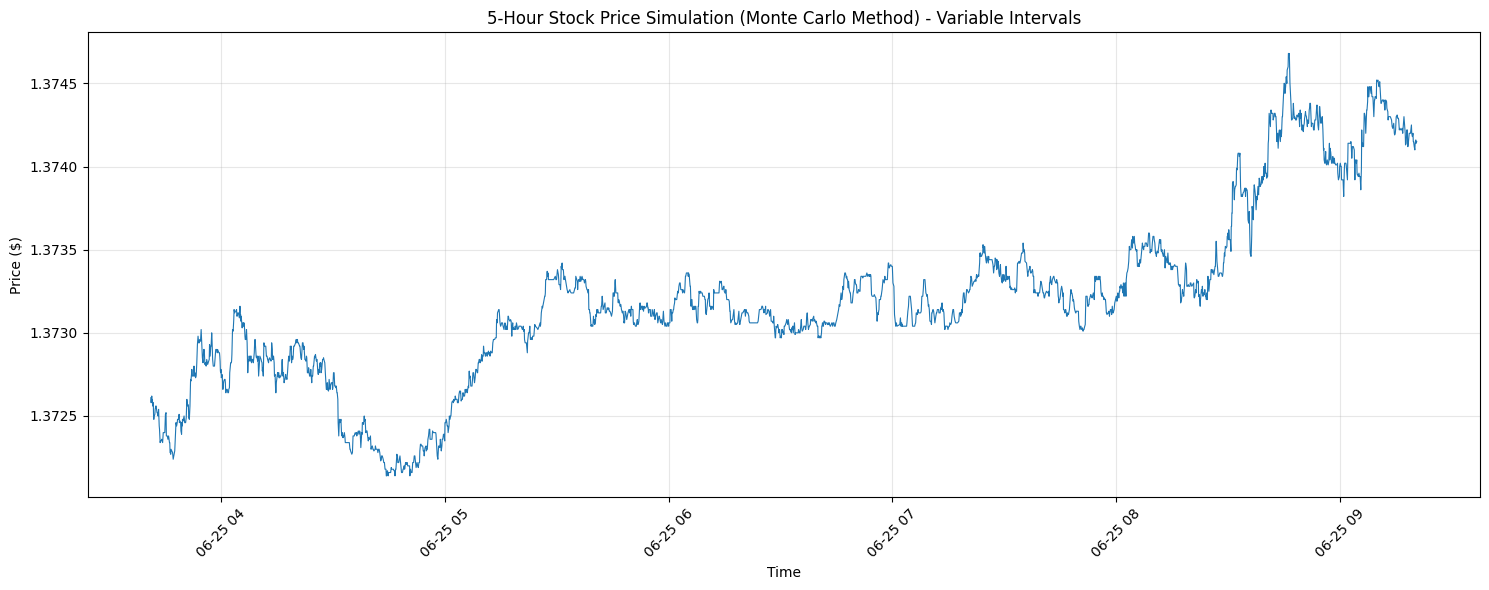

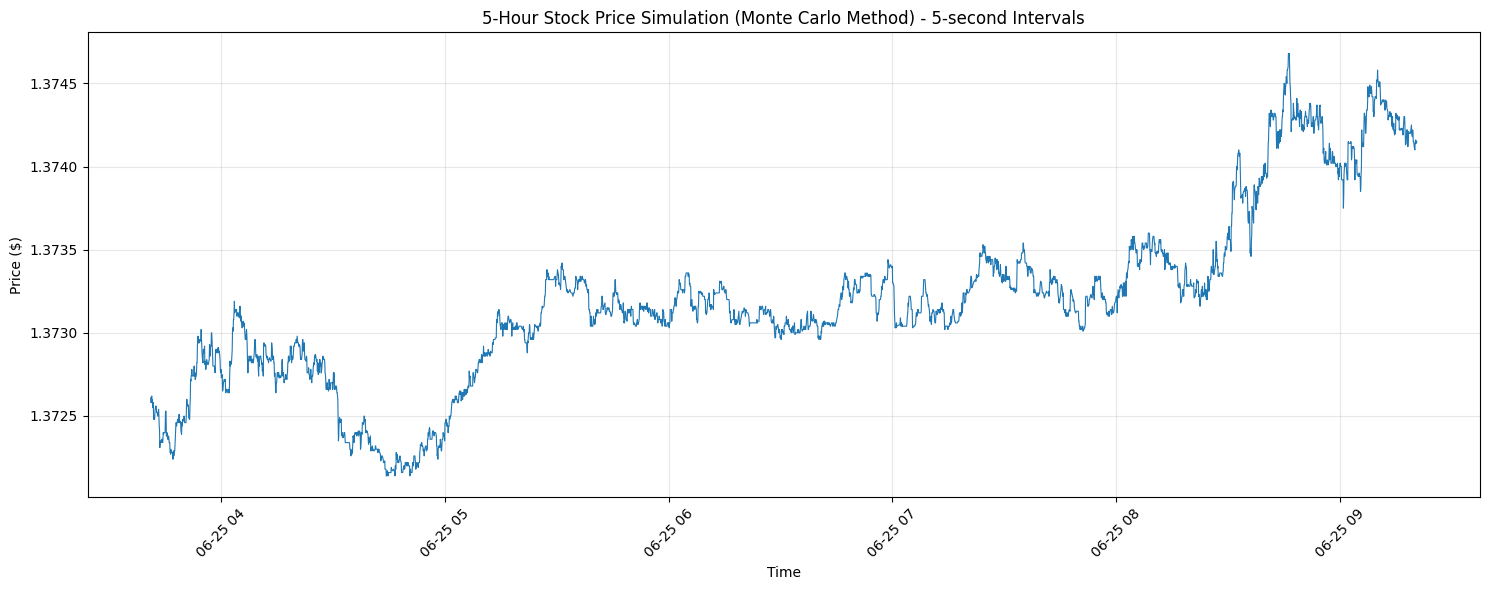

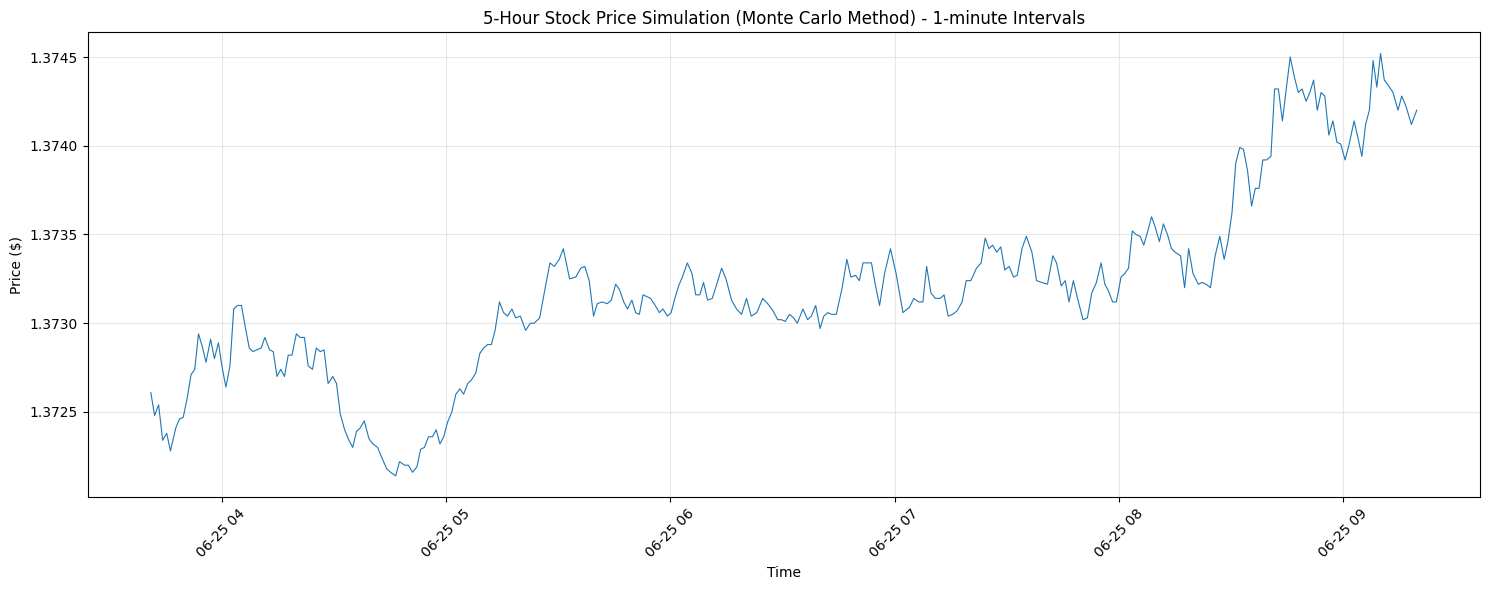

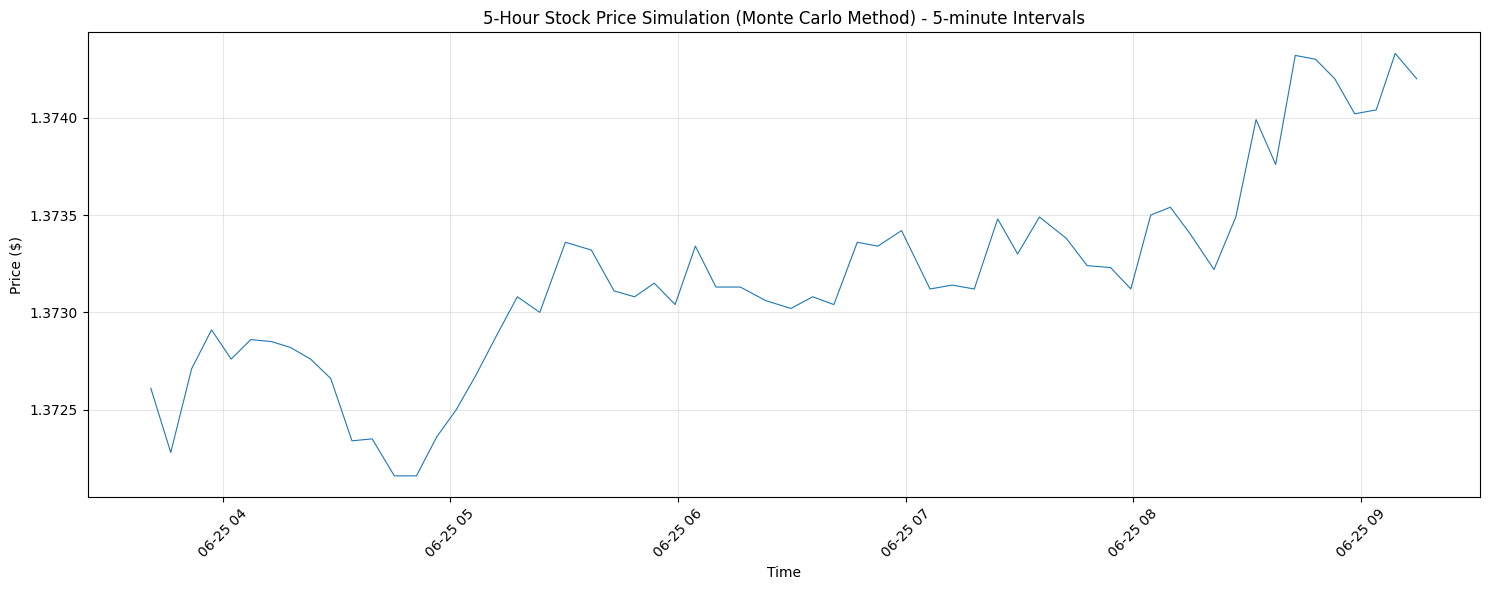

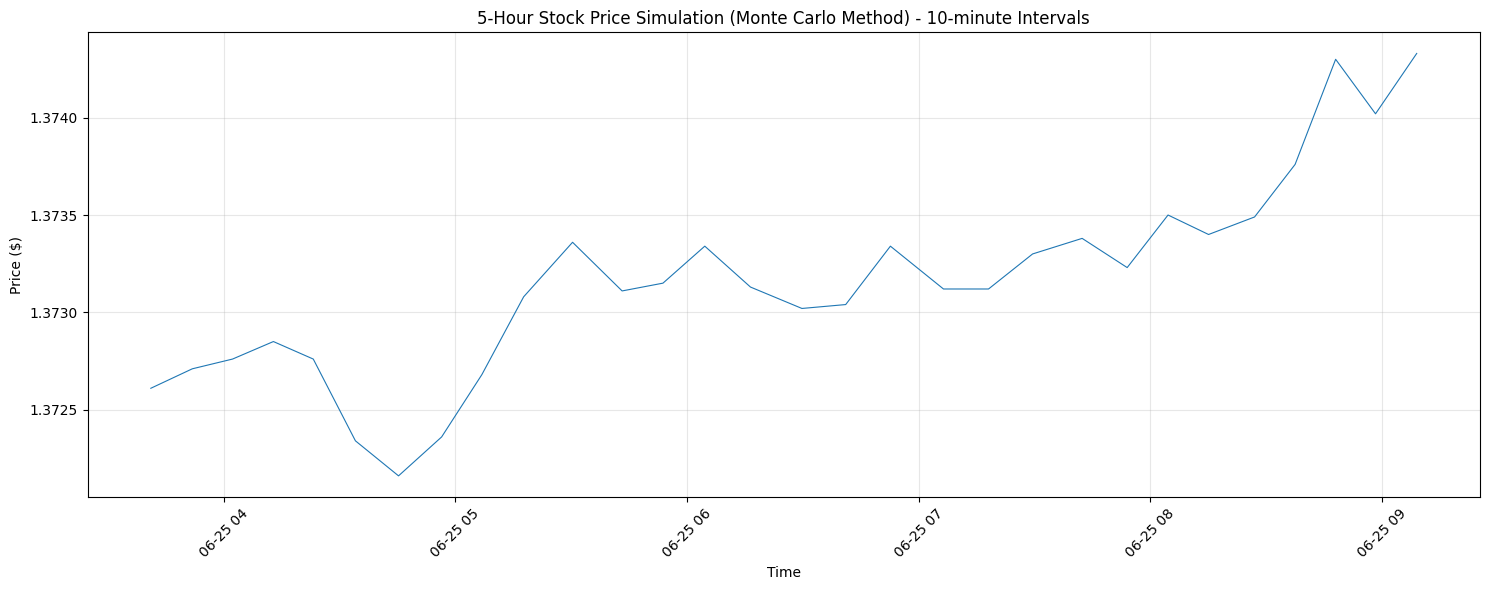

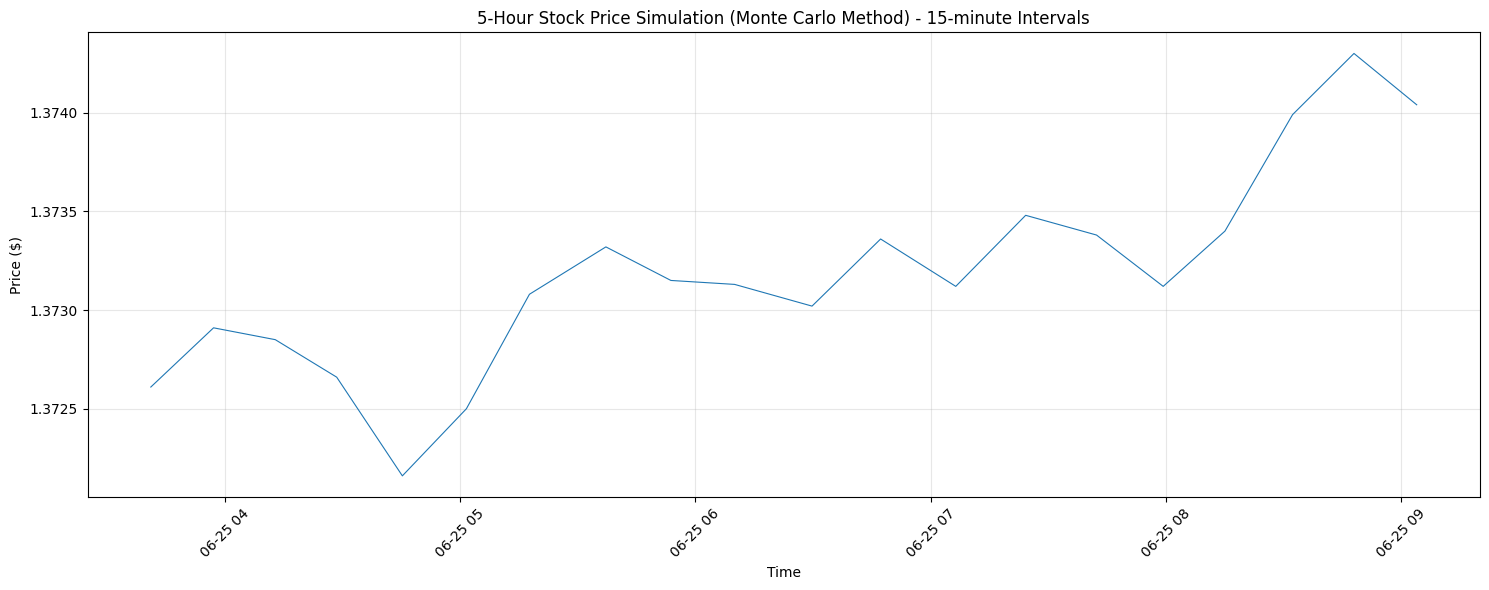

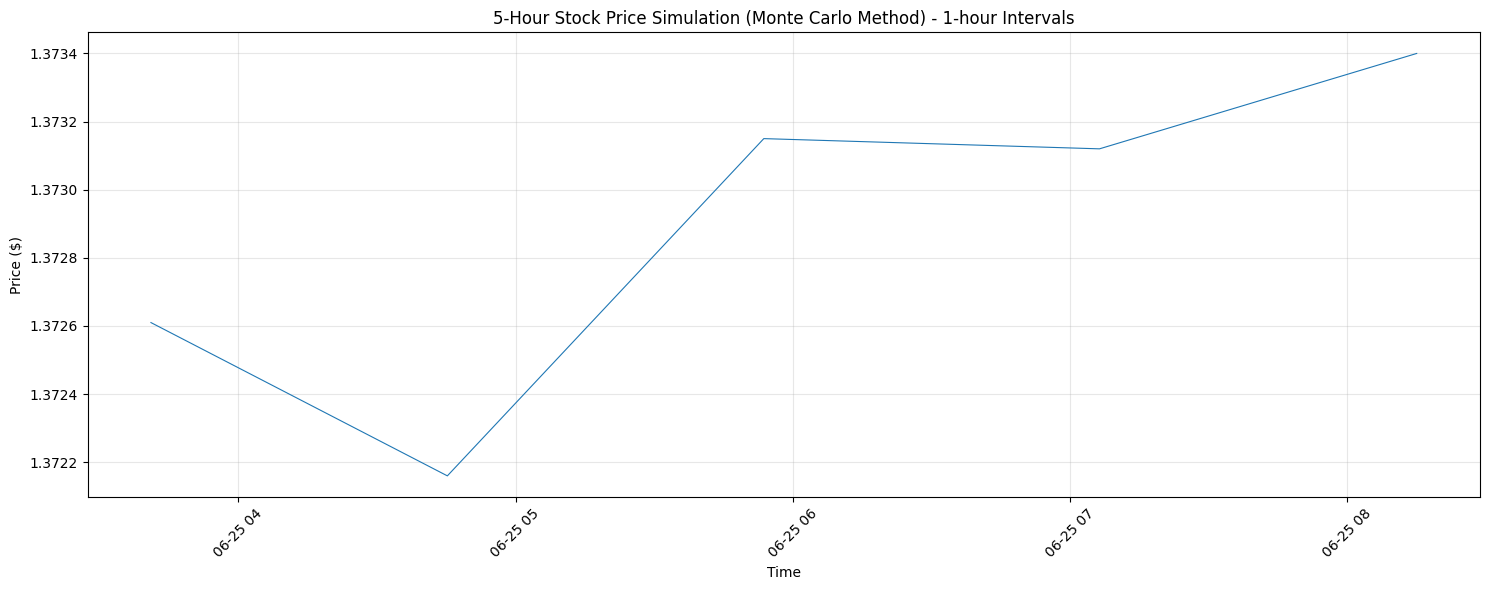

In [29]:
import numpy as np

# Generate the data with 5 seconds intervals for 23 hours
interval = 5  # 1 second intervals
hours = 23  
np.random.seed(42)  # For reproducible results

SOURCE = 2 # 1 = Monte Carlo, 2 = OANDA

# Generate stock price data using Monte Carlo method    
if SOURCE == 1:
    print("Generating stock price data using Monte Carlo method...")
    hours = int(input("Number of hours to fetch (e.g., 10): "))
    stock_df = generate_stock_price_data(interval=5, hours=hours) # 1-second intervals

if SOURCE == 2:
    # Generate stock data from OANDA API
    instrument = input("Instrument (e.g., USD_CAD): ")
    granularity = 'S5' # input("Granularity (e.g., S5, M1, M5): ")
    hours = int(input("Number of hours to fetch (e.g., 10): "))
    api_key = input("API Key please: ")
    stock_df = get_oanda_data(
        api_key=api_key,
        account_id='001-002-6172489-007',
        instrument=instrument,
        granularity=granularity,
        hours=hours
    )

# from stock_df, create different intervals
stock_5sec = stock_df.copy()
stock_1min = stock_df[::12].reset_index(drop=True)  # Every 12th row for 1-minute intervals
stock_5min =  stock_df[::60].reset_index(drop=True)  # Every 60th row for 5-minute intervals
stock_10min = stock_df[::120].reset_index(drop=True)  # Every 120th row for 10-minute intervals
stock_15min = stock_df[::180].reset_index(drop=True)  # Every 180th row for 15-minute intervals
stock_1hour = stock_df[::720].reset_index(drop=True)  # Every 720th row for 1-hour intervals
stock_variable = create_variable_interval_data(stock_df, min_interval=1, max_interval=2) # variable intervals


# Plot the stock price over the specified time period
for df, label in zip([stock_variable, stock_5sec, stock_1min, stock_5min, stock_10min, stock_15min, stock_1hour], 
                   ['Variable', '5-second', '1-minute', '5-minute', '10-minute', '15-minute', '1-hour']):
    plt.figure(figsize=(15, 6))
    plt.plot(df['timestamp'], df['price'], linewidth=0.8, label=f'{label} intervals')
    plt.title(f'{hours:.0f}-Hour Stock Price Simulation (Monte Carlo Method) - {label} Intervals')
    plt.xlabel('Time')
    plt.ylabel('Price ($)')
    plt.grid(True, alpha=0.3)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

# Execution: Choose your DF

In [30]:
df = None
df = stock_5sec.copy()  # Use the 5-second interval data for EMA calculation
# df = stock_1min.copy()  # Use the 1-minute interval data for EMA calculation
# df = stock_5min.copy()  # Use the 5-minute interval data for EMA calculation
# df = stock_1hour.copy()  # Use the 1-hour interval
# df = stock_variable.copy()  # Use the variable interval


# Execution: Add EMAs to entire Data Frame

In [ ]:

# Add EMA to the DataFrame
df['EMA_15min'] = calculate_time_based_ema(df, type=1, period_minutes=15)
# df['DEMA_15min'] = calculate_time_based_ema(df, type=2, period_minutes=15)
df['TEMA_15min'] = calculate_time_based_ema(df, type=3, period_minutes=15)

plot_time_series(df, exclude_columns=None)

# stock_df

# Execution: Process EMAs using streaming

In [32]:
import time

# Clean df
df = df[['timestamp', 'price']].copy()  # Keep only necessary columns

# 1. Create the calculator
ema_calc = TimeBasedStreamingMA('15min', ma_type='EMA')
tema_calc = TimeBasedStreamingMA('15min', ma_type='TEMA')

# initialize the json that will hold timestamp price and ema values
results_json = [] # list of dictionaries to hold results
ema_values = []
tema_values = []

# 2. Process the DataFrame
for _, row in df.iterrows():
    # wait 1 second to simulate real-time processing
    # time.sleep(1)  # Uncomment this line to simulate real-time processing
    timestamp = row['timestamp']
    price = row['price']

    # only from the first price, infer the precision
    if not ema_values:  # Only do this once
        precision = get_precision(price)

    ema = round(ema_calc.add_data_point(timestamp, price), precision)
    tema = round(tema_calc.add_data_point(timestamp, price), precision)
    ema_values.append(ema)  # EMA value
    tema_values.append(tema)  # TEMA value

    # Check for crossovers and store results in JSON format
    cross_direction = None
    
    # when tema crosses ema, detect the direction
    if len(ema_values) > 1 and len(tema_values) > 1:
        if (tema_values[-1] > ema_values[-1] and tema_values[-2] <= ema_values[-2]):
            cross_direction = 'up'
            print('up', timestamp, tema_values[-1], ema_values[-1])  # Print timestamp and values
        elif (tema_values[-1] < ema_values[-1] and tema_values[-2] >= ema_values[-2]):
            cross_direction = 'down'
            print('down', timestamp, tema_values[-1], ema_values[-1])  # Print timestamp and values

    # Store results in JSON format - include cross info only when crossing occurs
    result_entry = {
        "timestamp": timestamp.isoformat(),
        "price": price,
        "ema": ema,
        "tema": tema
    }
    
    # Add cross information only when there's a crossing
    if cross_direction:
        result_entry["cross"] = cross_direction
        result_entry["cross_timestamp"] = timestamp.isoformat()

    # add result_entry to a live plot and display it
    results_json.append(result_entry)
    

print(results_json)
# 3. Add to DataFrame
df['EMA_15min'] = ema_values
df['TEMA_15min'] = tema_values
# df['Other_15min'] = other_values  # If you have other values to track


down 2025-06-25 03:41:40 1.3726 1.37261
up 2025-06-25 03:52:30 1.37252 1.37251
down 2025-06-25 04:14:40 1.37284 1.37285
up 2025-06-25 04:20:45 1.37285 1.37284
up 2025-06-25 04:21:45 1.37286 1.37285
down 2025-06-25 04:23:30 1.37284 1.37285
down 2025-06-25 04:23:45 1.37283 1.37284
up 2025-06-25 04:56:20 1.3723 1.37229
down 2025-06-25 05:40:20 1.37319 1.3732
up 2025-06-25 06:02:55 1.37314 1.37313
up 2025-06-25 06:03:05 1.37315 1.37314
down 2025-06-25 06:17:30 1.37318 1.37319
up 2025-06-25 06:45:25 1.37306 1.37305
up 2025-06-25 06:45:45 1.37307 1.37306
down 2025-06-25 07:02:10 1.37321 1.37322
down 2025-06-25 07:20:10 1.37313 1.37314
up 2025-06-25 07:20:40 1.37315 1.37314
down 2025-06-25 07:40:00 1.37332 1.37333
down 2025-06-25 07:57:25 1.37321 1.37322
up 2025-06-25 08:02:25 1.37322 1.37321
down 2025-06-25 08:17:35 1.37339 1.3734
up 2025-06-25 08:29:20 1.37336 1.37335
down 2025-06-25 08:57:25 1.37418 1.37419
down 2025-06-25 08:57:40 1.37417 1.37418
up 2025-06-25 09:08:00 1.37413 1.37412
dow

In [ ]:

print(f'{len(df) = }') 
print(f'{len(ema_calc.timestamps) = }')
print(f'{len(ema_calc.data_points) = }')
print(f'{ema_calc.data_count = }')
print(f'{ema_calc.ema1 = }')
print(f'{ema_calc.ema2 = }')
print(f'{ema_calc.ema3 = }')
print(f'{ema_calc.last_timestamp = }')
print(f'{ema_calc.ma_type = }')
print(f'{ema_calc.time_window = }')
print(f'{ema_calc.time_window_str = }')
print(f'{ema_calc.alpha = }')
print(f'{ema_calc.initialized = }')
ema_calc.get_time_window_info()



len(df) = 3600
len(ema_calc.timestamps) = 150
len(ema_calc.data_points) = 150
ema_calc.data_count = 3600
ema_calc.ema1 = 1.3728585499535813
ema_calc.ema2 = None
ema_calc.ema3 = None
ema_calc.last_timestamp = Timestamp('2025-06-24 22:59:05')
ema_calc.ma_type = 'EMA'
ema_calc.time_window = Timedelta('0 days 00:15:00')
ema_calc.time_window_str = '15min'
ema_calc.alpha = 0.125
ema_calc.initialized = True


{'ma_type': 'Time-EMA',
 'time_window_spec': '15min',
 'time_window_seconds': 900.0,
 'data_points_count': 150,
 'total_data_processed': 3600,
 'current_ma': 1.3728585499535813,
 'oldest_timestamp': Timestamp('2025-06-24 22:44:05'),
 'newest_timestamp': Timestamp('2025-06-24 22:59:05'),
 'actual_time_span': 900.0,
 'window_utilization': 100.0,
 'base_alpha': 0.125,
 'initialized': True,
 'last_calculation_time': Timestamp('2025-06-24 22:59:05'),
 'ema1': 1.3728585499535813}

# Function: OANDA Live Streaming Prices

In [ ]:
import requests
import json
import time
from datetime import datetime
import threading
from queue import Queue

def stream_oanda_live_prices(api_key, account_id, instrument='USD_CAD', callback=None, max_duration=None):
    """
    Stream live prices from OANDA API for a single instrument
    
    Parameters:
    -----------
    api_key : str
        Your OANDA live API key
    account_id : str  
        Your OANDA live account ID
    instrument : str, default='USD_CAD'
        Single instrument to stream (e.g., 'EUR_USD', 'GBP_JPY')
    callback : function, optional
        Function to call with each price update: callback(timestamp, instrument, bid, ask, price)
    max_duration : int, optional
        Maximum streaming duration in seconds (None = unlimited)
    
    Returns:
    --------
    generator or None
        Yields price dictionaries or None if connection fails
    """
    
    # LIVE OANDA STREAMING API URL
    STREAM_URL = "https://stream-fxtrade.oanda.com"
    
    print("🔴 CONNECTING TO OANDA LIVE STREAMING")
    print("=" * 50)
    print("⚠️  WARNING: This connects to LIVE market stream")
    print(f"📊 Streaming: {instrument}")
    print(f"⏱️  Duration: {'Unlimited' if max_duration is None else f'{max_duration}s'}")
    print("=" * 50)
    
    # Validate inputs
    if not api_key:
        print("❌ ERROR: Live API key is required!")
        return None
    
    if not account_id:
        print("❌ ERROR: Live Account ID is required!")
        return None
    
    # Headers for streaming request
    headers = {
        'Authorization': f'Bearer {api_key}',
        'Accept': 'application/stream+json',
        'Content-Type': 'application/json'
    }
    
    # Streaming endpoint for prices
    url = f"{STREAM_URL}/v3/accounts/{account_id}/pricing/stream"
    
    # Parameters for streaming
    params = {
        'instruments': instrument,
        'snapshot': 'true'  # Include initial snapshot
    }
    
    try:
        print(f"🌐 Initiating streaming connection...")
        print(f"   URL: {url}")
        print(f"   Instrument: {instrument}")
        
        # Make streaming request
        response = requests.get(url, headers=headers, params=params, stream=True, timeout=30)
        
        # Check for HTTP errors
        if response.status_code == 401:
            print("❌ AUTHENTICATION ERROR (401)")
            print("   • Check your API key is correct")
            print("   • Ensure your API key has streaming permissions")
            return None
        elif response.status_code == 403:
            print("❌ FORBIDDEN ERROR (403)")
            print("   • Your account may not have streaming access")
            print("   • Check if your account is verified and funded")
            return None
        elif response.status_code == 404:
            print(f"❌ NOT FOUND ERROR (404)")
            print(f"   • Check instrument name: {instrument}")
            return None
        elif response.status_code != 200:
            print(f"❌ HTTP ERROR {response.status_code}")
            print(f"   Response: {response.text}")
            return None
        
        print("✅ Streaming connection established!")
        print("📈 Receiving live price updates...")
        print("   Press Ctrl+C to stop streaming")
        print("-" * 50)
        
        start_time = time.time()
        price_count = 0
        
        # Process streaming data line by line
        for line in response.iter_lines():
            # Check duration limit
            if max_duration and (time.time() - start_time) > max_duration:
                print(f"\n⏰ Reached maximum duration of {max_duration} seconds")
                break
                
            if line:
                try:
                    # Parse JSON data
                    data = json.loads(line.decode('utf-8'))
                    
                    # Handle different types of messages
                    if data.get('type') == 'PRICE':
                        price_count += 1
                        timestamp = datetime.now()
                        
                        # Extract price information
                        instrument_name = data.get('instrument', instrument)
                        
                        # Get bid/ask prices
                        bids = data.get('bids', [])
                        asks = data.get('asks', [])
                        
                        if bids and asks:
                            bid_price = float(bids[0]['price'])
                            ask_price = float(asks[0]['price']) 
                            mid_price = (bid_price + ask_price) / 2
                            spread_pips = (ask_price - bid_price) * 10000  # For most pairs
                            
                            # Create price dictionary
                            price_data = {
                                'timestamp': timestamp,
                                'instrument': instrument_name,
                                'bid': bid_price,
                                'ask': ask_price,
                                'price': mid_price,  # Mid price for compatibility
                                'spread_pips': round(spread_pips, 1),
                                'time': data.get('time', timestamp.isoformat()),
                                'tradeable': data.get('tradeable', True)
                            }
                            
                            # Print price update (every 10th update to avoid spam)
                            if price_count % 10 == 0:
                                print(f"💰 {timestamp.strftime('%H:%M:%S')} | {instrument_name} | "
                                      f"Bid: {bid_price:.5f} | Ask: {ask_price:.5f} | "
                                      f"Mid: {mid_price:.5f} | Spread: {spread_pips:.1f} pips")
                            
                            # Call callback function if provided
                            if callback:
                                try:
                                    callback(timestamp, instrument_name, bid_price, ask_price, mid_price)
                                except Exception as e:
                                    print(f"⚠️  Callback error: {e}")
                            
                            # Yield price data for generator usage
                            yield price_data
                            
                    elif data.get('type') == 'HEARTBEAT':
                        # Heartbeat to keep connection alive
                        if price_count % 100 == 0:  # Print occasionally
                            print(f"💓 Heartbeat - Connection alive ({price_count} prices received)")
                    
                    else:
                        # Other message types
                        print(f"📨 Message: {data.get('type', 'Unknown')} - {data}")
                        
                except json.JSONDecodeError as e:
                    print(f"⚠️  JSON decode error: {e}")
                    continue
                except Exception as e:
                    print(f"⚠️  Processing error: {e}")
                    continue
        
        print(f"\n✅ Streaming completed. Total prices received: {price_count}")
        
    except KeyboardInterrupt:
        print(f"\n🛑 Streaming stopped by user. Total prices received: {price_count}")
    except requests.exceptions.Timeout:
        print("❌ TIMEOUT ERROR: Streaming request timed out")
    except requests.exceptions.ConnectionError:
        print("❌ CONNECTION ERROR: Lost connection to OANDA")
    except Exception as e:
        print(f"❌ UNEXPECTED ERROR: {e}")
    finally:
        if 'response' in locals():
            response.close()

# Convenience function for simple price collection
def collect_streaming_prices(api_key, account_id, instrument='USD_CAD', duration=60):
    """
    Collect streaming prices for a specified duration and return as list
    
    Parameters:
    -----------
    api_key : str
        Your OANDA live API key
    account_id : str
        Your OANDA live account ID  
    instrument : str, default='USD_CAD'
        Instrument to stream
    duration : int, default=60
        Duration in seconds to collect prices
    
    Returns:
    --------
    list
        List of price dictionaries
    """
    prices = []
    
    def price_callback(timestamp, instrument, bid, ask, price):
        prices.append({
            'timestamp': timestamp,
            'instrument': instrument,
            'bid': bid,
            'ask': ask,
            'price': price
        })
    
    # Stream prices for specified duration
    try:
        for _ in stream_oanda_live_prices(api_key, account_id, instrument, 
                                         callback=price_callback, max_duration=duration):
            pass  # Prices are collected via callback
    except Exception as e:
        print(f"Collection error: {e}")
    
    return prices

print("✅ OANDA live streaming functions ready!")
print("\n🔧 USAGE EXAMPLES:")
print("# Stream indefinitely:")
print("for price in stream_oanda_live_prices(api_key, account_id, 'EUR_USD'):")
print("    print(f\"EUR/USD: {price['price']:.5f}\")")
print("\n# Collect prices for 60 seconds:")
print("prices = collect_streaming_prices(api_key, account_id, 'GBP_JPY', 60)")

api_key = input("Enter your OANDA live API key: ")
account_id = '001-002-6172489-007'
for price in stream_oanda_live_prices(api_key, account_id, 'EUR_USD'):
    print(f"EUR/USD: {price['price']:.5f}")

✅ OANDA live streaming functions ready!

🔧 USAGE EXAMPLES:
# Stream indefinitely:
for price in stream_oanda_live_prices(api_key, account_id, 'EUR_USD'):
    print(f"EUR/USD: {price['price']:.5f}")

# Collect prices for 60 seconds:
prices = collect_streaming_prices(api_key, account_id, 'GBP_JPY', 60)
